# 6 October 2021

## **Titanic dataset**

* Explore: Bagaimana setiap feature berhubungan dengan apakah seseorang survive/alive? Lakukan EDA secara lebih detail dari biasanya dan jelaskan hasil yang didapat!
* Splitting: 80-20, stratify: y, random_state = 0

* Preprocessing:
    * Drop deck
    * Isi missing value menggunakan simple imputer
    * One hot encoding: sex, alone
    * Ordinal encoding: class 
    * Binary encoding: embark town

* Model selection:
    * Evaluation metrics yang dipakai: F1_score
    * Logreg, KNN, DecisionTreeClassifier, RandomForestClassifier
    * Hyperparameter tuning 2 model yang menurut kalian terbaik
    * Buat summary untuk hasil evaluasi dan kesimpulan mana model yang terbaik untuk titanic dataset

Kalau bisa, gunakan pipeline ketika diperlukan untuk menghindari data leakage.

## **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')


## **Load data**

In [2]:
titanic = pd.read_csv('titanic.csv')
titanic

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,NaN,Southampton,no,True
887,female,19.0,0,30.0000,First,B,Southampton,yes,True
888,female,NaN,2,23.4500,Third,NaN,Southampton,no,False
889,male,26.0,0,30.0000,First,C,Cherbourg,yes,True


In [3]:
titanic['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

In [4]:
titanic.shape

(891, 9)

In [5]:
# Identify a single value in columns
titanic.nunique()

sex              2
age             88
parch            7
fare           248
class            3
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

In [6]:
titanic.describe(include=object)

,sex,class,deck,embark_town,alive
count,891,891,203,889,891
unique,2,3,7,3,2
top,male,Third,C,Southampton,no
freq,577,491,59,644,549


In [7]:
titanic['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

In [8]:
# if there is any missing values
titanic.isnull().sum()

sex              0
age            177
parch            0
fare             0
class            0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Age, deck, dan embark_town memiliki missing values. Untuk age dan embark_town, missing valuesnya akan diisi dengan menggunakan simple imputer, sedangkan feature deck nantinya akan didrop.

## **EDA**

### **Sex**

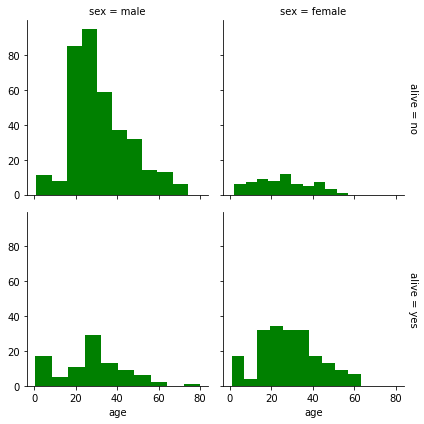

In [9]:
sex_alive = sns.FacetGrid(titanic, col='sex', row='alive', margin_titles=True)
sex_alive.map(plt.hist, 'age', color= 'green')
plt.show()

Berdasarkan gender, jumlah alive pada female secara signifikan jauh lebih banyak daripada male, dengan sebaran umur terbanyak berkisar dari 18 hingga 38.

### **Age**

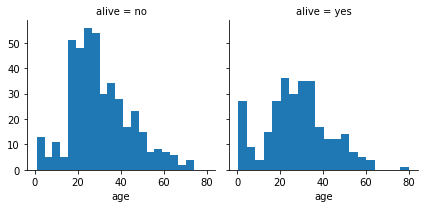

In [10]:
age_alive = sns.FacetGrid(titanic, col='alive')
age_alive.map(plt.hist, 'age', bins=20)
plt.show()

### **Class and Fare**

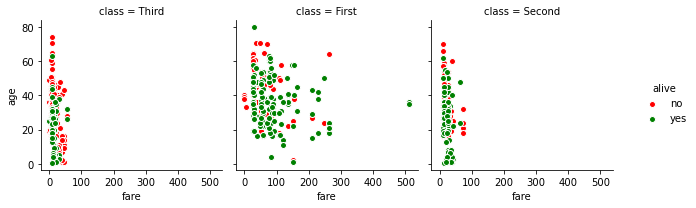

In [11]:
class_fare = sns.FacetGrid(titanic, hue='alive', col='class', margin_titles=True, palette={'yes':'green', 'no':'red'})
class_fare.map(plt.scatter, 'fare', 'age', edgecolor='w').add_legend()
plt.show()

In [12]:
titanic.groupby('class')['alive'].value_counts()

class   alive
First   yes      136
        no        80
Second  no        97
        yes       87
Third   no       372
        yes      119
Name: alive, dtype: int64

In [13]:
titanic.groupby('class')['alive'].value_counts()/titanic.shape[0]*100

class   alive
First   yes      15.263749
        no        8.978676
Second  no       10.886644
        yes       9.764310
Third   no       41.750842
        yes      13.355780
Name: alive, dtype: float64

- Jumlah penumpang terbanyak berasal dari kelas Third.
- Jumlah penumpang yang selamat paling banyak berasal dari kelas First (15%), diikuti oleh kelas Third (13%).

### **Age, Gender, Fare**

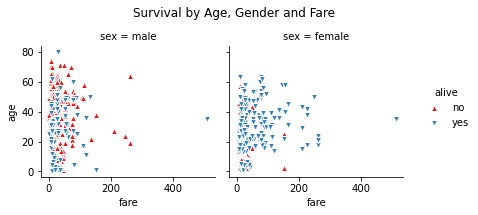

In [14]:
age_gender_fare = sns.FacetGrid(titanic, hue='alive', col='sex', margin_titles=True, palette='Set1', hue_kws=dict(marker=['^', 'v']))
age_gender_fare.map(plt.scatter, 'fare', 'age',edgecolor='w').add_legend()
plt.subplots_adjust(top=0.8)
age_gender_fare.fig.suptitle('Survival by Age, Gender and Fare')
plt.show()

In [15]:
titanic.groupby('sex')['alive'].value_counts()

sex     alive
female  yes      233
        no        81
male    no       468
        yes      109
Name: alive, dtype: int64

In [16]:
titanic.groupby('sex')['alive'].value_counts()/titanic.shape[0]*100

sex     alive
female  yes      26.150393
        no        9.090909
male    no       52.525253
        yes      12.233446
Name: alive, dtype: float64

- Jumlah penumpang female yang selamat melebihi 2 kali lipat dari jumlah penumpang male yang selamat.
- Lebih dari 50% dari total penumpang yang tidak selamat adalah gender male.

### **Embark Town**

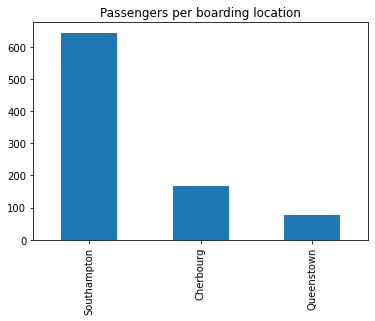

In [17]:
titanic.embark_town.value_counts().plot(kind='bar')
plt.title('Passengers per boarding location')
plt.show()

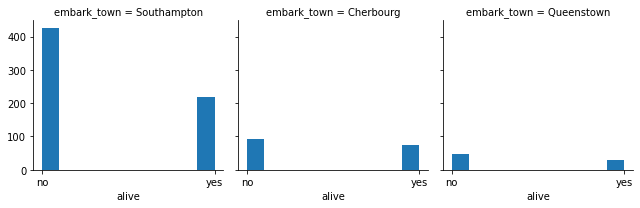

In [18]:
embark_alive = sns.FacetGrid(titanic, col='embark_town')
embark_alive.map(plt.hist, 'alive')
plt.show()

In [19]:
titanic.groupby('embark_town')['alive'].value_counts()

embark_town  alive
Cherbourg    yes       93
             no        75
Queenstown   no        47
             yes       30
Southampton  no       427
             yes      217
Name: alive, dtype: int64

In [20]:
titanic.groupby('embark_town')['alive'].value_counts()/titanic.shape[0]*100

embark_town  alive
Cherbourg    yes      10.437710
             no        8.417508
Queenstown   no        5.274972
             yes       3.367003
Southampton  no       47.923681
             yes      24.354658
Name: alive, dtype: float64

### **Embark Town and Class**

In [21]:
titanic.groupby('embark_town')['class'].value_counts()

embark_town  class 
Cherbourg    First      85
             Third      66
             Second     17
Queenstown   Third      72
             Second      3
             First       2
Southampton  Third     353
             Second    164
             First     127
Name: class, dtype: int64

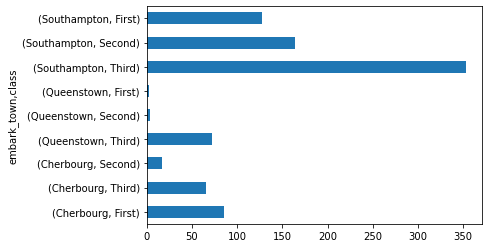

In [22]:
titanic.groupby('embark_town')['class'].value_counts().plot(kind='barh');

- Berdasarkan asal keberangkatannya, penumpang yang berangkat dari Southampton adalah yang terbanyak. 
- Namun, jika ditinjau dari titik keberangkatan, hanya Cherbourg yang memiliki rasio jumlah penumpang selamat yang lebih besar. Hal ini mungkin disebabkan karena penumpang dari Cherbourg adalah penumpang kelas First, yang kemungkinan didahulukan ketika bencana terjadi.

### **Alone**

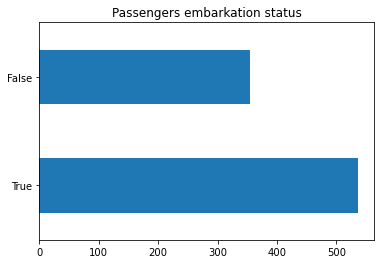

In [23]:
titanic.alone.value_counts().plot(kind='barh')
plt.title('Passengers embarkation status')
plt.show()

In [24]:
titanic.groupby('alone')['alive'].value_counts()

alone  alive
False  yes      179
       no       175
True   no       374
       yes      163
Name: alive, dtype: int64

In [25]:
titanic.groupby('alone')['class'].value_counts()

alone  class 
False  Third     167
       First     107
       Second     80
True   Third     324
       First     109
       Second    104
Name: class, dtype: int64

Penumpang yang berangkat sendirian lebih banyak yang tidak selamat. Kebanyakan penumpang yang berangkat sendirian adalah penumpang kelas Third.

## **Preprocessing scheme**

In [26]:
ordinal_mapping= [
    {'col':'class',
    'mapping': {None:0, 'First':1, 'Second':2, 'Third':3}}]
ordinal_encoder = ce.OrdinalEncoder(cols = 'class', mapping=ordinal_mapping)

In [27]:
binary_encoder_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary encoder', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'), ['sex', 'alone']),
    ('ordinal encoding', ordinal_encoder, ['class']),
    ('simple imputer', SimpleImputer(strategy='median'), ['age']),
    ('binary encoder', binary_encoder_pipeline, ['embark_town'])
], remainder='passthrough')

## **Data Splitting**

In [28]:
X = titanic.drop(columns = ['alive', 'deck'])
y = np.where(titanic['alive'] == 'yes', 1, 0)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.2,
    stratify = y,
    random_state = 0)

## **Data Transformation**

In [30]:
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [31]:
X_train_prep = pd.DataFrame(X_train_prep)
X_test_prep = pd.DataFrame(X_test_prep)

In [32]:
transformer.transformers_

[('one hot encoder', OneHotEncoder(drop='first'), ['sex', 'alone']),
 ('ordinal encoding',
  OrdinalEncoder(cols=['class'],
                 mapping=[{'col': 'class',
                           'mapping': {None: 0, 'First': 1, 'Second': 2,
                                       'Third': 3}}]),
  ['class']),
 ('simple imputer', SimpleImputer(strategy='median'), ['age']),
 ('binary encoder',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('binary encoder', BinaryEncoder())]),
  ['embark_town']),
 ('remainder', 'passthrough', [2, 3])]

In [33]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_male', 'x1_True'], dtype=object)

In [34]:
transformer.transformers_[1][1].get_feature_names()

['class']

In [35]:
transformer.transformers_[3][1][1].get_feature_names()

['0_0', '0_1', '0_2']

In [36]:
features = list(transformer. transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1].get_feature_names() + ['age'] + transformer.transformers_[3][1][1].get_feature_names() + ['parch', 'fare']
X_train_prep.columns = features
X_test_prep.columns = features
X_train_prep

,x0_male,x1_True,class,age,0_0,0_1,0_2,parch,fare
0,0.0,1.0,3.0,28.0,0.0,0.0,1.0,0.0,7.6292
1,1.0,1.0,3.0,28.0,0.0,1.0,0.0,0.0,8.0500
2,0.0,1.0,3.0,28.0,0.0,0.0,1.0,0.0,7.7500
3,0.0,0.0,1.0,51.0,0.0,1.0,0.0,0.0,77.9583
4,1.0,1.0,3.0,21.0,0.0,0.0,1.0,0.0,7.7333
...,...,...,...,...,...,...,...,...,...
707,1.0,1.0,3.0,20.0,0.0,1.0,0.0,0.0,7.0500
708,1.0,0.0,3.0,28.0,0.0,1.0,0.0,0.0,19.9667
709,1.0,1.0,3.0,39.0,0.0,1.0,0.0,0.0,7.9250
710,1.0,0.0,3.0,28.0,0.0,1.0,1.0,0.0,21.6792


In [37]:
X_test_prep

,x0_male,x1_True,class,age,0_0,0_1,0_2,parch,fare
0,1.0,0.0,3.0,40.5,0.0,1.0,0.0,2.0,14.5000
1,1.0,1.0,3.0,33.0,0.0,1.0,0.0,0.0,9.5000
2,0.0,0.0,3.0,39.0,0.0,1.0,0.0,5.0,31.2750
3,1.0,1.0,3.0,28.0,0.0,1.0,0.0,0.0,9.5000
4,0.0,1.0,1.0,24.0,0.0,1.0,1.0,0.0,83.1583
...,...,...,...,...,...,...,...,...,...
174,1.0,1.0,1.0,71.0,0.0,1.0,1.0,0.0,34.6542
175,0.0,0.0,2.0,45.0,0.0,1.0,0.0,1.0,26.2500
176,1.0,1.0,3.0,25.0,0.0,1.0,0.0,0.0,7.6500
177,1.0,1.0,3.0,19.0,0.0,1.0,0.0,0.0,14.5000


In [38]:
# Check missing values
X_train_prep.isna().sum()

x0_male    0
x1_True    0
class      0
age        0
0_0        0
0_1        0
0_2        0
parch      0
fare       0
dtype: int64

In [39]:
X_test_prep.isna().sum()

x0_male    0
x1_True    0
class      0
age        0
0_0        0
0_1        0
0_2        0
parch      0
fare       0
dtype: int64

## **Model Performance**

In [40]:
# Define models
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)

# Define imbalance treatment methods
models = [knn, tree, logreg, rf]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [41]:
pd.DataFrame({
    'model':['knn', 'tree', 'logreg', 'rf'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,0.568421,0.055999
1,tree,0.719023,0.043662
2,logreg,0.719123,0.041412
3,rf,0.758543,0.023324


Dari hasil di atas, dapat dilihat bahwa model random forest memiliki performa paling baik dan stabil jika dilihat dari nilai rata-rata F1 score-nya dan standar deviasinya. Sedangkan untuk logistic regression dan decisition tree, hasilnya hanya berbeda sedikit, tapi logistic regression sedikit lebih baik.

## **Model Performance on Test Set**

In [42]:
models={
    'Logistic Regression': LogisticRegression(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0),  
}

score=[]

for i in models:
    models[i].fit(X_train_prep, y_train)
    y_pred=models[i].predict(X_test_prep)
    score.append([f1_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['F1 score'], index = models.keys())
score_before_tuning


,F1 score
Logistic Regression,0.703125
Random Forest,0.687500


## **Hyperparamater Tuning**

In [43]:
# Logistic Regression
hyperparam_space_logreg = {
    'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [100, 200, 300, 400, 500, 1000]

}

# Random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 12, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

hyperparam_space_rf = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [44]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

logreg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)

random_logreg = RandomizedSearchCV(
    logreg,
    param_distributions = hyperparam_space_logreg,
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

random_rf = RandomizedSearchCV(
    rf, 
    param_distributions = hyperparam_space_rf,
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

In [45]:
random_logreg.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=LogisticRegression(random_state=0), n_jobs=-1,
                   param_distributions={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5,
                                              0.1, 0.05, 0.01, 0.005, 0.001,
                                              0.0005, 0.0001],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     1000],
                                        'solver': ['liblinear', 'newton-cg',
                                                   'lbfgs']},
                   scoring='f1')

In [46]:
random_rf.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='f1')

In [47]:
print('Best score logreg:', random_logreg.best_score_)
print('Best params logreg:', random_logreg.best_params_)
print('Best score rf:', random_rf.best_score_)
print('Best params rf:', random_rf.best_params_)

Best score logreg: 0.7356436826369317
Best params logreg: {'solver': 'lbfgs', 'max_iter': 200, 'C': 100}
Best score rf: 0.781023358445859
Best params rf: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


## **Model Performance After Tuning**

In [48]:
logreg_tuning = random_logreg.best_estimator_
logreg_tuning.fit(X_train_prep, y_train)

rf_tuning = random_rf.best_estimator_
rf_tuning.fit(X_train_prep, y_train)

y_pred_logreg_tuning = logreg_tuning.predict(X_test_prep)
y_pred_rf_tuning = rf_tuning.predict(X_test_prep)

f1_logreg_tuning = f1_score(y_test, y_pred_logreg_tuning)
f1_rf_tuning = f1_score(y_test, y_pred_rf_tuning)

In [49]:
score_list = [f1_logreg_tuning, f1_rf_tuning]
models = ['Logistic Regression', 'Random Forest']
score_after_tuning = pd.DataFrame({
    'Model': models,
    'F1 score': score_list
})

## **Comparison of f1_score**

In [50]:
score_before_tuning

,F1 score
Logistic Regression,0.703125
Random Forest,0.687500


In [51]:
score_after_tuning

,Model,F1 score
0,Logistic Regression,0.703125
1,Random Forest,0.724409


## **Summary**

1. Model terbaik untuk memprediksi seseorang berhasil survive atau tidak pada titanic dataset berdasarkan f1_scorenya adalah Random Forest dengan hyperparamater tuning.
2. Proses hyperparamater tuning membuat f1_score pada model random forest meningkat sekitar 0.04, dari 0.68 menjadi 0.72. Lain halnya dengan model logistic regression yang tidak mengalami perubahan sama sekali pada f1_scorenya.